# DeepFool Demo

- Team member: Zihan Wang, Songlin Liu, Bingzhao Shan

- Date: Feb 09

Replication Summary:

- Experiment done on a two-layer fully connected neural network on MNIST [Section2]

- Generated adversarial samples using DeepFool and FGSM for visual comparison [Section3]

- Quantative evaluation between DeepFool and FGSM [Section4]

- Fine-tuning experiment and over-perpurbed experiment [Section5]



## 1.Setup

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time 
import matplotlib.pyplot as plt


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

## 2.Initialize an NN and get the accuracy on the original test set

In [ ]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784,500)
    self.fc2 = nn.Linear(500,150)
    self.fc3 = nn.Linear(in_features=150, out_features=10)
  
  def forward(self, x):
    x = x.view(-1,784)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x


# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Transform to normalized Tensors 
transform = transforms.Compose([transforms.ToTensor(),])
                                # transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('./MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./MNIST/', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
# Convert to numpy array 
x_train = next(iter(train_loader))[0].numpy()
x_test = next(iter(test_loader))[0].numpy()
y_train = next(iter(train_loader))[1].numpy()
y_test = next(iter(test_loader))[1].numpy()

def convert_1hot(data):
  rows = len(data)
  cols = 10
  new_data = np.zeros((rows,cols))
  for idx, i in enumerate(data):
    new_data[idx,i] = 1
  return new_data
y_train = convert_1hot(y_train)
y_test = convert_1hot(y_test)

# Step 2: Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Step 2a: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.03)

# Step 3: Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# add the original accuracy on the test dataset
df_accuracy_on_original_test_set = [accuracy * 100]
fg_accuracy_on_original_test_set = [accuracy * 100]
df_accuracy_on_original_test_set_alpha2 = [accuracy * 100]
df_accuracy_on_original_test_set_alpha3 = [accuracy * 100]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)





Accuracy on benign test examples: 93.39%


## 3. Visual Demo (DeepFool v.s. FGSM)

In [ ]:
def render_frame(image, logits, ground_truth):
    # actually draw the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # image
    ax1.imshow(image[0], cmap='gray')
    fig.sca(ax1)
    plt.xticks([])
    plt.yticks([])
    
    # classification
    probs = np.exp(logits) / sum(np.exp(logits))
    topk = probs.argsort()[::-1]
    topprobs = probs[topk]
    barlist = ax2.bar(range(10), topprobs)
    for i, v in enumerate(topk):
        if i == 0:
            barlist[i].set_color('r')
        if v == ground_truth:
            barlist[i].set_color('g')
        
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), [i for i in topk])
    fig.subplots_adjust(bottom=0.1)

    # save the plot
    # path = os.path.join('./adv-examples', f'gt-{ground_truth}.png')
    # if os.path.exists(path):
    #     os.remove(path)
    # plt.savefig(path)



def render_frame_compare(image, df_adv, fgs_adv, df_logits, fgs_logits, ground_truth):


    # actually draw the figure
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(16, 3))

    # the raw image
    ax1.imshow(image[0], cmap='gray')
    fig.sca(ax1)
    plt.xticks([])
    plt.yticks([])

    # show the difference
    ax2.imshow(df_adv[0] - image[0], cmap='gray')
    fig.sca(ax2)
    plt.xticks([])
    plt.yticks([])

    # df_adv
    ax3.imshow(df_adv[0], cmap='gray')
    fig.sca(ax3)
    plt.xticks([])
    plt.yticks([])
    
    # df classification
    probs = np.exp(df_logits) / sum(np.exp(df_logits))
    topk = probs.argsort()[::-1]
    topprobs = probs[topk]
    barlist = ax4.bar(range(10), topprobs)
    for i, v in enumerate(topk):
        if i == 0:
            barlist[i].set_color('r')
        if v == ground_truth:
            barlist[i].set_color('g')
        
    plt.sca(ax4)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), [i for i in topk])


    # fg_adv diff
    ax5.imshow(fgs_adv[0] - image[0], cmap='gray')
    fig.sca(ax5)
    plt.xticks([])
    plt.yticks([])

    # fg_adv diff
    ax6.imshow(fgs_adv[0], cmap='gray')
    fig.sca(ax6)
    plt.xticks([])
    plt.yticks([])


    # df classification
    probs = np.exp(fgs_logits) / sum(np.exp(fgs_logits))
    topk = probs.argsort()[::-1]
    topprobs = probs[topk]
    barlist = ax7.bar(range(10), topprobs)
    for i, v in enumerate(topk):
        if i == 0:
            barlist[i].set_color('r')
        if v == ground_truth:
            barlist[i].set_color('g')
        
    plt.sca(ax7)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), [i for i in topk])
    
    # fgsm classification
    # probs = np.exp(fgs_adv) / sum(np.exp(fgs_logits))
    # topk = probs.argsort()[::-1]
    # topprobs = probs[topk]
    # barlist = ax5.bar(range(10), topprobs)
    # for i, v in enumerate(topk):
    #     if i == 0:
    #         barlist[i].set_color('r')
    #     if v == ground_truth:
    #         barlist[i].set_color('g')
        
    # plt.sca(ax5)
    # plt.ylim([0, 1.1])
    # plt.xticks(range(10), [i for i in topk])
    # fig.subplots_adjust(bottom=0.1)


    


In [ ]:
# attack the test dataset using deep fool
attack = DeepFool(classifier=classifier,max_iter=50,batch_size=64,epsilon=0.02)
visual_demo_test_df = attack.generate(x=x_test)

# attack the test dataset using fgsm
attack2 = FastGradientMethod(estimator=classifier, eps=0.25, eps_step=1e-2, targeted=False, batch_size=64, minimal=True)
visual_demo_test_fgs = attack2.generate(x=x_test)

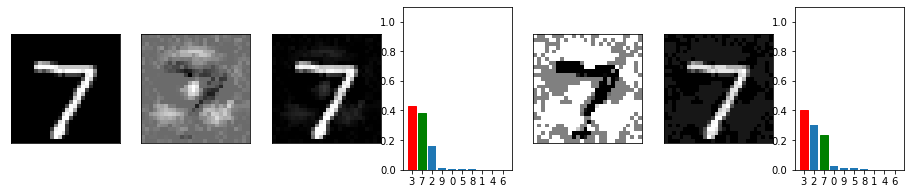

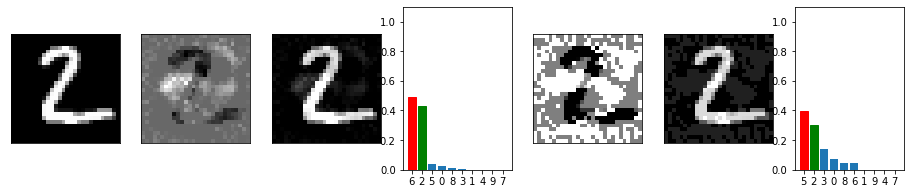

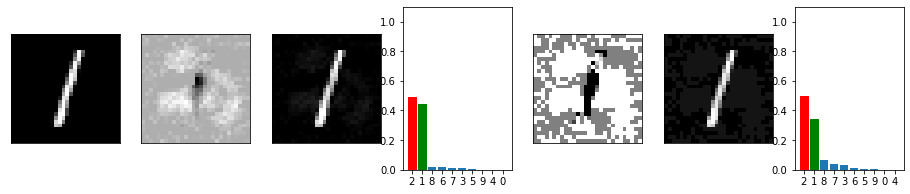

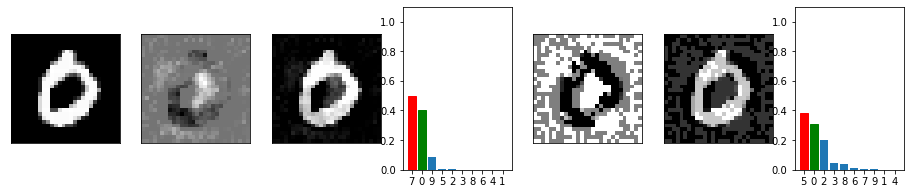

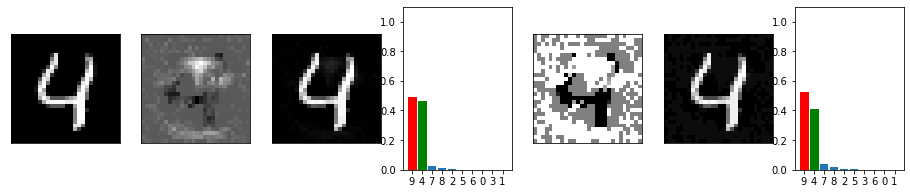

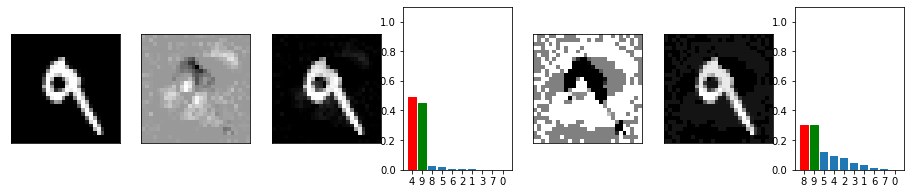

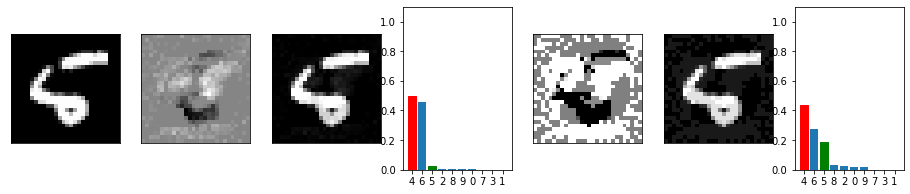

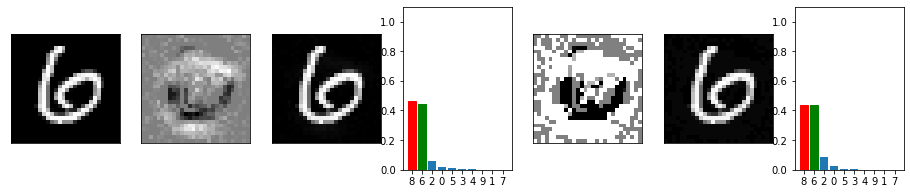

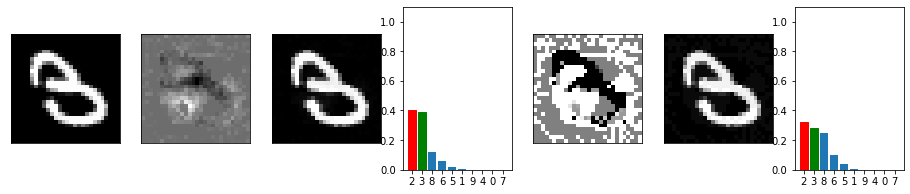

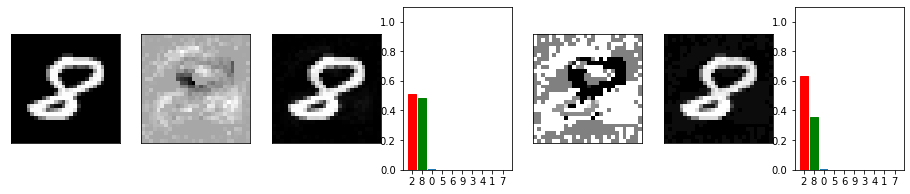

In [ ]:
# visual_demo_test_df.shape
# plt.figure(figsize = (20,2))
# plt.imshow(visual_demo_test_df[100, 0, :], cmap='gray')

# predictions = np.argmax(classifier.predict(visual_demo_test_df), axis=1)
# y_true = np.argmax(y_test, axis=1)

# render_frame(visual_demo_test_df[10, :], predictions[10], y_true[10])  


df_predictions = classifier.predict(visual_demo_test_df)
fgs_predictions = classifier.predict(visual_demo_test_fgs)
y_true = np.argmax(y_test, axis=1)
visited = []

for i in range(visual_demo_test_df.shape[0]):
    if len(visited) == 10:
        break
    
    y = np.argmax(y_test[i])
    if y in visited:
        continue

    pred = np.argmax(df_predictions[i])
    if y == pred:
        continue
    
    pred = np.argmax(fgs_predictions[i])
    if y == pred:
        continue
    
    visited.append(y)
    render_frame_compare(x_test[i], visual_demo_test_df[i], visual_demo_test_fgs[i], df_predictions[i], fgs_predictions[i], y)   



# From left to right:
# Raw image   --->  deepfool - raw image ---> deepfool ---> deepfool confidence ---> fgsm - raw image ---> fgsm ---> fgsm confidence

## 4. Attack using DeepFool and FGSM

In [ ]:
# raw_image_tensor: N x H x W x C
# perturbed_tensor: N x H x W x C
# Note: they must be of the same order
# Note: perturbed tensor is the tensor generated by DeepFool, prediction label should be different

def robustness(image_tensor, perturbed_tensor):

    # get the data size
    assert image_tensor.shape == perturbed_tensor.shape
    N = image_tensor.shape[0]

    # get the perturbation
    r = image_tensor - perturbed_tensor

    rval = 0
    for i in range(N):

        # l2 norm on r
        norm_r = np.sqrt(np.sum(r[i, :]**2))

        # l2 norm on x
        norm_x = np.sqrt(np.sum(image_tensor[i, :]**2))

        # accumulate
        rval += norm_r / norm_x

    return rval / N


# image_tensor = np.ones((2, 2, 2, 1))
# perturbed_tensor = np.ones((2, 2, 2, 1))
# perturbed_tensor[:, 0, 0, :] = 0
# print(robustness(image_tensor, perturbed_tensor))


In [ ]:
t0 = time.time()
# Step 6: Generate (untargeted) adversarial test examples
attack = DeepFool(classifier=classifier,max_iter=50,batch_size=64,epsilon=0.02)
x_train_adv_dp = attack.generate(x=x_train)
old_x_test_adv_dp = attack.generate(x=x_test)
print("DeepFool time: {} s".format(time.time()-t0))

# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(old_x_test_adv_dp)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
all_rob_dp = []
all_rob_dp.append(robustness(x_test, old_x_test_adv_dp))
all_rob_fg = []

# for over-perpurtabation
all_rob_dp2 = []
all_rob_dp3 = []
all_rob_dp2.append(robustness(x_test, old_x_test_adv_dp))
all_rob_dp3.append(robustness(x_test, old_x_test_adv_dp))

# evaluation of robustness is done using deepfool
all_rob_fg.append(robustness(x_test, old_x_test_adv_dp))
print("DeepFool: Accuracy on adversarial test examples: {}%".format(accuracy * 100))


t0 = time.time()
# fg_attack = FastGradientMethod(estimator=classifier, eps=0.2, targeted=False)
attack = FastGradientMethod(estimator=classifier, eps=0.25, eps_step=1e-2, targeted=False, batch_size=64, minimal=True)
x_train_adv_fg = attack.generate(x=x_train)
old_x_test_adv_fg = attack.generate(x=x_test)
print("FGSM time: {} s".format(time.time()-t0))

# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(old_x_test_adv_fg)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print("FGSM: Accuracy on adversarial test examples: {}%".format(accuracy * 100))



DeepFool time: 730.7994379997253 s
DeepFool: Accuracy on adversarial test examples: 3.95%
FGSM time: 26.078370332717896 s
FGSM: Accuracy on adversarial test examples: 4.02%


## 5. Fine-tune & over-perpurtabed experiment

In [ ]:

# make a copy of the model
import copy
model_copy = copy.deepcopy(model)
classifier_copy = copy.deepcopy(classifier)


# Step 8: Fine-tunning with adversial examples 


# DeepFool alpha = 3
# optimizer = optim.Adam(classifier.model.parameters(), lr=0.005)
classifier = copy.deepcopy(classifier_copy)
optimizer = optim.SGD(classifier.model.parameters(), lr=0.015)
classifier.optimizer = optimizer
for i in range(5):
  print("DeepFool Current epoch alpha=2:" + str(i+1))

  
  # over purterbed alpha=2
  classifier.fit((x_train_adv_dp - x_train)*3 + x_train, y_train, batch_size=64, nb_epochs=1)

  # evaluation is based on deepfool
  attack = DeepFool(classifier=classifier, max_iter=50, batch_size=64, epsilon=0.02)
  x_test_adv_dp = attack.generate(x=x_test)
  rob = robustness(x_test, x_test_adv_dp)
  all_rob_dp3.append(rob)

  # accuracy on the first perturbed dataset
  predictions = classifier.predict(old_x_test_adv_dp)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("DeepFool Accuracy on adversarial test examples alpha=3: {}%".format(accuracy * 100))

  # accuracy on the original dataset
  predictions = classifier.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  df_accuracy_on_original_test_set_alpha3.append(accuracy * 100)



# DeepFool alpha = 2
# optimizer = optim.Adam(classifier.model.parameters(), lr=0.005)
classifier = copy.deepcopy(classifier_copy)
optimizer = optim.SGD(classifier.model.parameters(), lr=0.015)
classifier.optimizer = optimizer
for i in range(5):
  print("DeepFool Current epoch alpha=2:" + str(i+1))

  
  # over purterbed alpha=2
  classifier.fit((x_train_adv_dp - x_train)*2 + x_train, y_train, batch_size=64, nb_epochs=1)

  # evaluation is based on deepfool
  attack = DeepFool(classifier=classifier, max_iter=50, batch_size=64, epsilon=0.02)
  x_test_adv_dp = attack.generate(x=x_test)
  rob = robustness(x_test, x_test_adv_dp)
  all_rob_dp2.append(rob)

  # accuracy on the first perturbed dataset
  predictions = classifier.predict(old_x_test_adv_dp)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("DeepFool Accuracy on adversarial test examples alpha=2: {}%".format(accuracy * 100))

  # accuracy on the original dataset
  predictions = classifier.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  df_accuracy_on_original_test_set_alpha2.append(accuracy * 100)





# DeepFool alpha = 1
classifier = copy.deepcopy(classifier_copy)
# optimizer = optim.Adam(classifier.model.parameters(), lr=0.005)
optimizer = optim.SGD(classifier.model.parameters(), lr=0.015)
classifier.optimizer = optimizer
for i in range(5):
  print("DeepFool Current epoch:" + str(i+1))
  classifier.fit(x_train_adv_dp, y_train, batch_size=64, nb_epochs=1)

  # evaluation is based on deepfool
  attack = DeepFool(classifier=classifier, max_iter=50, batch_size=64, epsilon=0.02)
  x_test_adv_dp = attack.generate(x=x_test)
  rob = robustness(x_test, x_test_adv_dp)
  all_rob_dp.append(rob)

  # accuracy on the first perturbed dataset
  predictions = classifier.predict(old_x_test_adv_dp)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("DeepFool Accuracy on adversarial test examples: {}%".format(accuracy * 100))

  # accuracy on the original dataset
  predictions = classifier.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  df_accuracy_on_original_test_set.append(accuracy * 100)





# FGSM
classifier2 = copy.deepcopy(classifier_copy)
# optimizer2 = optim.Adam(classifier2.model.parameters(), lr=0.005)
optimizer2 = optim.SGD(classifier2.model.parameters(), lr=0.015)
classifier2.optimizer = optimizer2
for i in range(5):
  print("FGSM Current epoch:" + str(i+1))
  classifier2.fit(x_train_adv_fg, y_train, batch_size=64, nb_epochs=1)

  # evaluation on deepfool
  attack = DeepFool(classifier=classifier2,max_iter=50,batch_size=64,epsilon=0.02)
  x_test_adv_fg = attack.generate(x=x_test)
  rob = robustness(x_test, x_test_adv_fg)
  all_rob_fg.append(rob)

  # accuracy on the first perturbed dataset
  predictions = classifier2.predict(old_x_test_adv_fg)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("FGSM Accuracy on adversarial test examples: {}%".format(accuracy * 100))

  # accuracy on the original test dataset
  predictions = classifier2.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  fg_accuracy_on_original_test_set.append(accuracy * 100)



DeepFool Current epoch alpha=2:1



DeepFool Accuracy on adversarial test examples alpha=3: 86.53%
DeepFool Current epoch alpha=2:2



DeepFool Accuracy on adversarial test examples alpha=3: 92.77%
DeepFool Current epoch alpha=2:3



DeepFool Accuracy on adversarial test examples alpha=3: 95.46%
DeepFool Current epoch alpha=2:4



DeepFool Accuracy on adversarial test examples alpha=3: 95.78%
DeepFool Current epoch alpha=2:5



DeepFool Accuracy on adversarial test examples alpha=3: 96.2%
DeepFool Current epoch alpha=2:1



DeepFool Accuracy on adversarial test examples alpha=2: 90.11%
DeepFool Current epoch alpha=2:2



DeepFool Accuracy on adversarial test examples alpha=2: 94.85%
DeepFool Current epoch alpha=2:3



DeepFool Accuracy on adversarial test examples alpha=2: 96.11%
DeepFool Current epoch alpha=2:4



DeepFool Accuracy on adversarial test examples alpha=2: 96.56%
DeepFool Current epoch alpha=2:5



DeepFool Accuracy on adversarial test examples alpha=2: 96.76%
DeepFool Current epoch:1



DeepFool Accuracy on adversarial test examples: 91.91%
DeepFool Current epoch:2



DeepFool Accuracy on adversarial test examples: 94.69999999999999%
DeepFool Current epoch:3



DeepFool Accuracy on adversarial test examples: 96.21%
DeepFool Current epoch:4



DeepFool Accuracy on adversarial test examples: 96.6%
DeepFool Current epoch:5



DeepFool Accuracy on adversarial test examples: 96.53%
FGSM Current epoch:1



FGSM Accuracy on adversarial test examples: 93.8%
FGSM Current epoch:2



FGSM Accuracy on adversarial test examples: 95.6%
FGSM Current epoch:3



FGSM Accuracy on adversarial test examples: 96.35000000000001%
FGSM Current epoch:4



FGSM Accuracy on adversarial test examples: 96.67%
FGSM Current epoch:5



FGSM Accuracy on adversarial test examples: 97.04%


### 5.1 DeepFool v.s. FGSM (avg robustness, fine-tuned model)

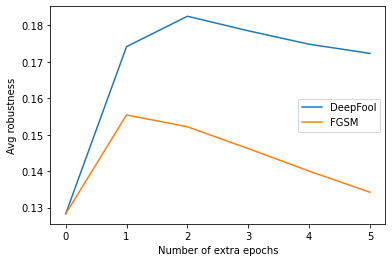

In [ ]:
plt.plot(np.arange(6), all_rob_dp, label="DeepFool")
plt.plot(np.arange(6), all_rob_fg, label="FGSM")
plt.xlabel('Number of extra epochs')
plt.ylabel('Avg robustness')
plt.legend()

### 5.2 DeepFool v.s. FGSM (accuracy on the original test dataset, fine-tuned model)

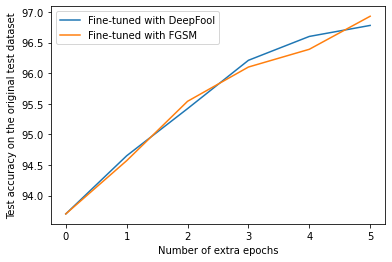

In [ ]:
plt.plot(np.arange(6), df_accuracy_on_original_test_set, label="Fine-tuned with DeepFool")
plt.plot(np.arange(6), fg_accuracy_on_original_test_set, label="Fine-tuned with FGSM")
plt.xlabel('Number of extra epochs')
plt.ylabel('Test accuracy on the original test dataset')
plt.legend()

### 5.3 DeepFool: over-perturbed samples and robustness

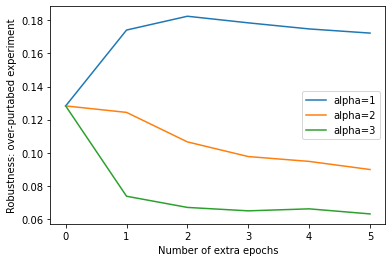

In [ ]:
plt.plot(np.arange(6), all_rob_dp, label="alpha=1")
plt.plot(np.arange(6), all_rob_dp2, label="alpha=2")
plt.plot(np.arange(6), all_rob_dp3, label="alpha=3")
plt.xlabel('Number of extra epochs')
plt.ylabel('Robustness: over-purtabed experiment')
plt.legend()

### 5.4 DeepFool: over-purtabed samples and accuracy on the original test dataset

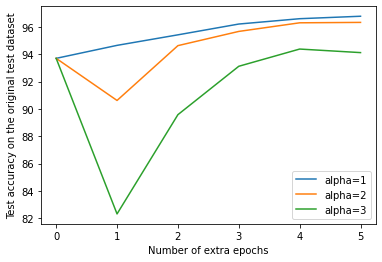

In [ ]:
plt.plot(np.arange(6), df_accuracy_on_original_test_set, label="alpha=1")
plt.plot(np.arange(6), df_accuracy_on_original_test_set_alpha2, label="alpha=2")
plt.plot(np.arange(6), df_accuracy_on_original_test_set_alpha3, label="alpha=3")
plt.xlabel('Number of extra epochs')
plt.ylabel('Test accuracy on the original test dataset')
plt.legend()